In this worksheet we will develop a Molecular Dynamics program for interacting systems, such as a number of atoms interacting through pair potentials.

As always we start by importing the scientific and plotting functions so that we can use them in this notebook:

In [1]:
%pylab inline
import nglview as nv
import MDAnalysis as mda

Populating the interactive namespace from numpy and matplotlib


First we define the pair potential, i.e., the interaction energy between any two atoms. We will use the truncated and shifted Lennard-Jones interaction, with a cutoff at $r_c$:

In [2]:
def u(r):
    if r >= rc:
        return 0.0
    else:
        return 4.0 * (r**-12 - r**-6) - 4*(rc**-12 - rc**-6)

Once we have the pair potential, we can calculate the total potential energy by summing over all distinct pairs of atoms:

In [3]:
def compute_potential_energy():
    """Computes the total potential energy of the system."""

    N = positions.shape[0]                      # there are as many atoms as there are positions
    
    Epot = 0.
    for i in range(0, N-1):
        for j in range(i+1, N):
            rij = positions[j] - positions[i]   # rij is the distance vector from particle i to particle j
            r = sqrt(dot(rij, rij))             # calculate the magnitude of the distance: r = |rij| = sqrt( r_ij * r_ij )

            Epot += u(r)                        # add potential energy of this pair to total

    # return the copmuted energy to the calling program
    return Epot

If the total potential energy is pairwise additive and of the form
$$
U = \sum_{i=1}^{N-1} \sum_{j=i+1}^{N} u(r_{ij})
$$
then the force acting on atom $i$ is
$$
\boldsymbol{F}_i = - \nabla_i U = \sum_{j \neq i} u'(r_{ij}) \frac{\boldsymbol{r}_{ij}}{|\boldsymbol{r}_{ij}|} 
= \sum_{j \neq i} f(r_{ij}) \frac{\boldsymbol{r}_{ij}}{|\boldsymbol{r}_{ij}|} 
$$
where we introduced the new function $f(r) = u'(r)$ and the shorthand $\boldsymbol{r}_{ij} = \boldsymbol{r}_{j} - \boldsymbol{r}_{i}$.
If the pair potential is the Lennard-Jones potential, then
$$
f(r) = u'(r) =  -24 \epsilon \left[2 \frac{\sigma^{12}}{r^{13}} - \frac{\sigma^{6}}{r^{7}} \right]
$$
If the pair potential is truncated and shifted at $r_c$, then the resulting force is also truncated at $r_c$.

Let's implement this in our code. First we define a function to calculate the magnitude of the force between two particles as a function of their distance:

In [4]:
def f(r):
    if r >= rc:
        return 0.0
    else:
        return -24.*(2*r**-13 - r**-7)

In every Molecular Dynamics timestep we have to calculate the forces for each pair of atoms:

In [5]:
def compute_forces():
    """Computes forces between all pairs of particles."""

    N = positions.shape[0]                      # there are as many atoms as there are positions

    # define an array where we will store the force acting on each particle
    forces = np.zeros ((N,3), dtype=float)

    # loop over all particle pairs (i,j), and calculate the force those particle exert on each other
    for i in range(0, N-1):
        for j in range(i+1, N):
            rij = positions[j] - positions[i]   # rij is the distance vector from particle i to particle j
            r = sqrt(np.dot (rij, rij))         # calculate the magnitude of the distance: r = |rij| = sqrt( r_ij * r_ij )

            forces[i] += f(r) * rij / r         # add force to particle i
            forces[j] -= f(r) * rij / r         # add force to particle j

    # return the computed force array to the calling program
    return forces

It is not really necessary for the Velocity Verlet algorithm, but it is often useful to know what the kinetic energy is:

In [6]:
def compute_kinetic_energy():
    """Computes the total kinetic energy of the system."""

    Ekin = 0.5 * np.sum(velocities**2)
    return Ekin


The last thing we need is the Velocity Verlet algorithm that performs a single timestep on the system:

In [7]:
def perform_timestep():
    global positions, velocities, forces # we have to tell python that we are modifying global objects
    velocities += 0.5 * dt * forces      # Step 1: calcuate velocities at time t + dt/2    
    positions += dt * velocities         # Step 2: calculate positions at time t + dt
    forces = compute_forces()            # Step 3: calculate forces for new positions at time t + dt
    velocities += 0.5 * dt * forces      # Step 4: calculate velocities at time t + dt
    return positions, velocities, forces

That's it! Now let's test what we've put together so far.

## Collision of two (almost) hard spheres

We have not yet specified a cutoff radius where to truncate and shift the Lennard-Jones potential. Let's start with the seemingly odd choice $r_c = 2^{1/6} \sigma$, which happens to be the distance at which the Lennard-Jones potential has its minimum:

In [8]:
rc = 2**(1./6.)

With this choice the pair potential looks like this:

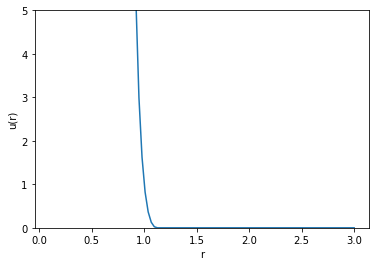

In [9]:
distances = linspace(0.1,3,100)
plot (distances, [u(r) for r in distances])
ylim(0,5)
xlabel("r")
ylabel("u(r)")
savefig("wca_pot.png")

This pair potential is sometimes called the Weeks-Chandler-Andersen (WCA) potential. It is the repulsive part of the Lennard-Jones potential, and has no attractive region at all. Atoms with this pair interaction essentially behave like hard spheres, as we will see below.

Before we start a simulation we have to specify the timestep for the Velocity Verlet algorithm:

In [10]:
dt = 0.01

Let's consider two atoms in a cubic simulation box of sidelength $10 \sigma$. The first atom starts at position $\boldsymbol{r}_1 = (0,0,0)$ with velocity $\boldsymbol{v}_1 = (1,0,0)$, while the second atom starts at position $\boldsymbol{r}_2 = (5,0,0)$ at rest (velocity $\boldsymbol{v}_2 = (0,0,0)$). We specify this intial condition, and then execute the Velocity Verlet algorithm `Nsteps` times:

In [11]:
# set the initial condition: positions and velocities of all atoms, as well as the simulation box size:

positions = array([[0,0,0],[5,0,0]], dtype=float)
velocities = array([[1,0,0],[0,0,0]], dtype=float)

# now we reserve some space to store the x coordinates of the two atoms, as well as the potential end kinetic energy of the system:

Nsteps = 800

x1 = zeros (Nsteps)
x2 = zeros (Nsteps)
Epot = zeros (Nsteps)
Ekin = zeros (Nsteps)

forces = compute_forces()
for step in range(Nsteps):
    x1[step] = positions[0,0]
    x2[step] = positions[1,0]
    Epot[step] = compute_potential_energy()
    Ekin[step] = compute_kinetic_energy()

    perform_timestep()
    

Done! Let's plot the x-coordinates of our two atoms as a function of timestep:

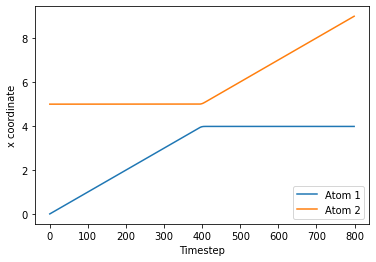

In [12]:
plot(x1,label="Atom 1")
plot(x2,label="Atom 2")
xlabel("Timestep")
ylabel("x coordinate")
legend(loc="lower right")
savefig("two_spheres_x.png")

Here is a plot of the potential, kinetic, and total energy as a function of timestep:

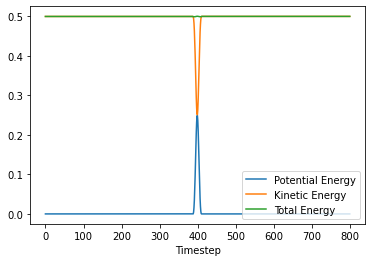

In [13]:
plot(Epot,label="Potential Energy")
plot(Ekin,label="Kinetic Energy")
plot(Epot+Ekin,label="Total Energy")
xlabel("Timestep")
legend(loc="lower right")
savefig("two_spheres_e.png")

#### Exercise 1: Explain what is going on in these two plots!

Wouldn't it be nice if we could watch a movie of the trajectory we just generated? Unfortunately we cannot do that within this Notebook, but we can save the trajectory and then use the program [VMD](http://www.ks.uiuc.edu/Research/vmd/) to visualize it.

To do this we have to learn how to save the trajectory data to a file. We have to choose a file format that VMD can read. While our simulation code uses a dimensionless unit system, VMD assumes that lengths are given in Angstroms. For visualization purposes only we will pretend that our Atoms are argon, which has a diameter of 3.76 Angstrom. All we need to do is multiply all lengths of our dimensionless simulation by 3.76.

Here is a function that saves the current configuration in a VMD-compatible format to a file. It uses the XYZ format, first writes the number of atoms, then an empty line, and then for each atom its type (here: Ar) and its x, y and z coordinate: 

In [14]:
def write_configuration(f):
    "Write the current configuration to the file f in XYZ format"
    N = positions.shape[0]
    print (N, file=f)
    print ("", file=f)
    for pos in positions:
        print ("Ar ", 3.76 * pos[0], 3.76 * pos[1], 3.76 * pos[2], file=f)

Now let's rerun the simulation above, but this time we write the configuration to a file:

In [15]:
# set the initial condition: positions and velocities of all atoms, as well as the simulation box size:

positions = array([[0,0,0],[5,0,0]], dtype=float)
velocities = array([[1,0,0],[0,0,0]], dtype=float)

# now we reserve some space to store the x coordinates of the two atoms, as well as the potential end kinetic energy of the system:

Nsteps = 800

xyzfilename = "output.xyz"
xyzfile = open(xyzfilename, "w")      # open the trajectory file in write mode

forces = compute_forces()
for step in range(Nsteps):
    write_configuration(xyzfile)      # save configuration to trajectory file
    perform_timestep()

xyzfile.close()                       # close trajectory file

In [16]:
two_spheres = mda.Universe("output.xyz")
two_spheres_view = nv.show_mdanalysis(two_spheres)
two_spheres_view

NGLWidget(max_frame=799)

Let's take a look! Start VMD, and choose "New Molecule..." from the "File" menu. Click on the "Browse" button next to  "Filename" and navigate to the directory this Notebook is in, and there should be the output file "output.xyz". Then select "Load", and VMD should be loading the trajectory.

Most likely the visualization window will not show anything quite yet. The reason is that VMD is typically used to visualize very complicated structures rather than something as simple as a few argon atoms. We first have to tell VMD to show every single atom. To do that, go to the "Graphics" menu and select "Representations...". A new window will open that contains a menu for the "Drawing Method", which is by default set to "Lines". Go ahead and change that to "VDW", and two spheres (representing our two atoms) should appear in the visualization window.

You can now use the VCR-style controls in the VMD main window to rewind to the beginning of the trajectory and then play the movie. If one or both of the atoms leave the visible view, you can select "Reset View" from the "Display" menu to readjust the view (which you can also do by pressing the "=" key while the visualization window is the active one).

## Collision of multiple spheres

Let's consider a different initial condition, this time using 4 atoms. We will also modify our code to create an additional output file that stores the potential and kinetic energy as a function of time:

In [17]:
# set the initial condition: positions and velocities of all atoms, as well as the simulation box size:

positions = array([[0,0,0],[5,0,0],[6,1,0],[6,-1,0]], dtype=float)
velocities = array([[1,0,0],[0,0,0],[0,0,0],[0,0,0]], dtype=float)

# now we reserve some space to store the x coordinates of the two atoms, as well as the potential end kinetic energy of the system:

Nsteps = 800

xyzfilename = "multiple_spheres.xyz"
xyzfile = open(xyzfilename, "w")      # open the trajectory file in write mode
energyfilename = "multiple_spheres_energy.dat"
energyfile = open(energyfilename,"w") # open the energy file in write mode

forces = compute_forces()
for step in range(Nsteps):
    write_configuration(xyzfile)      # save configuration to trajectory file
    print (step*dt, compute_potential_energy(), compute_kinetic_energy(), file=energyfile)    # save energies to file
    perform_timestep()

energyfile.close()                    # close energy file
xyzfile.close()                       # close trajectory file

Look at the generated trajectory file in VMD! Because we also saved the energies in a file, we can now load that file and analyze the energies:

In [18]:
energy = loadtxt(energyfilename)

What does this data look like?

In [19]:
print (energy)

[[0.         0.         0.5       ]
 [0.01       0.         0.5       ]
 [0.02       0.         0.5       ]
 ...
 [7.97       0.         0.49996095]
 [7.98       0.         0.49996095]
 [7.99       0.         0.49996095]]


``energy`` is a two-dimensional array with 3 columns and as many rows as there were timesteps. The first column is the time, the second is the potential energy, and the third is the kinetic energy. Let's take a look at what those look like:

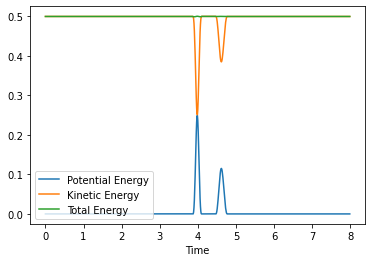

In [20]:
times = energy[:,0]    # the first column
Epot = energy[:,1]     # the second column
Ekin = energy[:,2]     # the third column
plot (times, Epot, label="Potential Energy")
plot (times, Ekin, label="Kinetic Energy")
plot (times, Epot+Ekin, label="Total Energy")
xlabel("Time")
legend(loc="lower left")
savefig("multiple_spheres_e.png")

In [21]:
multiple_spheres = mda.Universe("multiple_spheres.xyz")
multiple_spheres_view = nv.show_mdanalysis(multiple_spheres)
multiple_spheres_view

NGLWidget(max_frame=799)

We see that while the potential and kinetic energies are not conserved, the sum of the two is -- as it should be!

## Collision of two Lennard-Jones atoms

Let's revisit the collision of just two atoms, but this time we use a different cutoff where we truncate and shift the Lennard-Jones potential:

In [22]:
rc = 2.5

The pair potential now looks like this:

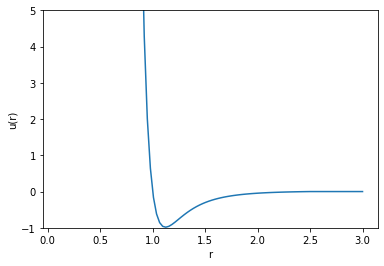

In [23]:
distances = linspace(0.1,3,100)
plot (distances, [u(r) for r in distances])
ylim(-1,5)
xlabel("r")
ylabel("u(r)")
savefig("LJ_pot.png")

We see that the potential now has a minimum and is attractive at intermediate distances. Let's run the simulation as before:

In [24]:
# set the initial condition: positions and velocities of all atoms, as well as the simulation box size:

positions = array([[0,0,0],[5,0,0]], dtype=float)
velocities = array([[1,0,0],[0,0,0]], dtype=float)

# now we reserve some space to store the x coordinates of the two atoms, as well as the potential end kinetic energy of the system:

Nsteps = 800

xyzfilename = "multiple_spheres.xyz"
xyzfile = open(xyzfilename, "w")      # open the trajectory file in write mode
energyfilename = "multiple_spheres_energy.dat"
energyfile = open(energyfilename,"w") # open the energy file in write mode

x1 = zeros (Nsteps)
x2 = zeros (Nsteps)
Epot = zeros (Nsteps)
Ekin = zeros (Nsteps)

forces = compute_forces()
for step in range(Nsteps):
    x1[step] = positions[0,0]
    x2[step] = positions[1,0]
    Epot[step] = compute_potential_energy()
    Ekin[step] = compute_kinetic_energy()

    perform_timestep()
    

In [25]:
# set the initial condition: positions and velocities of all atoms, as well as the simulation box size:

positions = array([[0,0,0],[5,0,0]], dtype=float)
velocities = array([[1,0,0],[0,0,0]], dtype=float)

# now we reserve some space to store the x coordinates of the two atoms, as well as the potential end kinetic energy of the system:

Nsteps = 800

xyzfilename = "LJ_two.xyz"
xyzfile = open(xyzfilename, "w")      # open the trajectory file in write mode
energyfilename = "LJ_two_energy.dat"
energyfile = open(energyfilename,"w") # open the energy file in write mode


forces = compute_forces()
for step in range(Nsteps):
    write_configuration(xyzfile)      # save configuration to trajectory file
    print (step*dt, compute_potential_energy(), compute_kinetic_energy(), file=energyfile)    # save energies to file
    perform_timestep()

energyfile.close()                    # close energy file
xyzfile.close()                       # close trajectory file

In [26]:
LJ_two = mda.Universe("LJ_two.xyz")
LJ_two_view = nv.show_mdanalysis(LJ_two)
LJ_two_view

NGLWidget(max_frame=799)

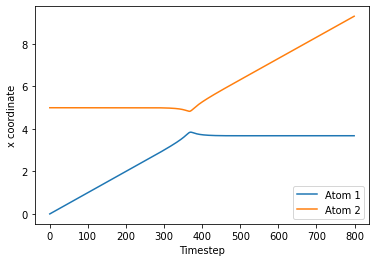

In [27]:
plot(x1,label="Atom 1")
plot(x2,label="Atom 2")
xlabel("Timestep")
ylabel("x coordinate")
legend(loc="lower right")
savefig("LJ_two_x.png")

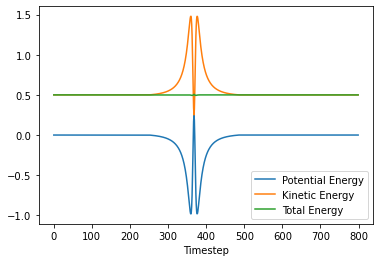

In [28]:
plot(Epot,label="Potential Energy")
plot(Ekin,label="Kinetic Energy")
plot(Epot+Ekin,label="Total Energy")
xlabel("Timestep")
legend(loc="lower right")
savefig("LJ_two_e.png")

#### Exercise 2: Explain what is going on in these two plots, especially the difference two the previous case in which two atoms interacted through the WCA potential!

In the WCA, there is only repulsive force between two particles, while in the LJ potential, there is some attractive force. This shows in both the movie and in the plots of coordinates and energies. When the particles get close in the WCA potential, they do not interact until they are close enough to generate repusivle forces. In the LJ potential, the two atoms first interact with an attractive force so their kinetic energy increases before they experience a repulsive force. 

## Shooting a single atom at a small cluster

We are now considering a single atom that is moving toward a stationary cluster of three argon atoms:

In [29]:
# set the initial condition: positions and velocities of all atoms, as well as the simulation box size:

positions = array([[0,0,0],[5,0,0],[5+1.12*cos(pi/6),1.12*sin(pi/6),0],[5+1.12*cos(pi/6),-1.12*sin(pi/6),0]], dtype=float)
velocities = array([[1,0,0],[0,0,0],[0,0,0],[0,0,0]], dtype=float)

# now we reserve some space to store the x coordinates of the two atoms, as well as the potential end kinetic energy of the system:

Nsteps = 2000

xyzfilename = "cluster.xyz"
xyzfile = open(xyzfilename, "w")      # open the trajectory file in write mode
energyfilename = "cluster_energy.dat"
energyfile = open(energyfilename,"w") # open the energy file in write mode

forces = compute_forces()
for step in range(Nsteps):
    write_configuration(xyzfile)      # save configuration to trajectory file
    print (step*dt, compute_potential_energy(), compute_kinetic_energy(), file=energyfile)    # save energies to file
    perform_timestep()

energyfile.close()                    # close energy file
xyzfile.close()                       # close trajectory file

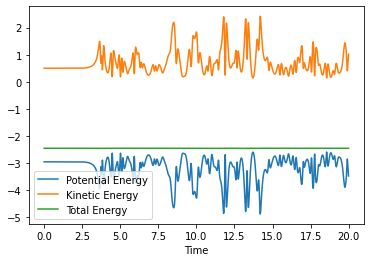

In [30]:
energy = loadtxt(energyfilename)
times = energy[:,0]    # the first column
Epot = energy[:,1]     # the second column
Ekin = energy[:,2]     # the third column
plot (times, Epot, label="Potential Energy")
plot (times, Ekin, label="Kinetic Energy")
plot (times, Epot+Ekin, label="Total Energy")
xlabel("Time")
legend(loc="lower left")
savefig("cluster_e.png")

#### Exercise 3: Watch the trajectory in VMD! Describe what happened!

In [31]:
cluster = mda.Universe("cluster.xyz")
cluster_view = nv.show_mdanalysis(cluster)
cluster_view

NGLWidget(max_frame=1999)

#### Exercise 4: Change the initial velocity of the incoming atom from (1,0,0) to (3,0,0). Run the simulation, watch the trajectory in VMD, and describe what happens!

In [32]:
# set the initial condition: positions and velocities of all atoms, as well as the simulation box size:

positions = array([[0,0,0],[5,0,0],[5+1.12*cos(pi/6),1.12*sin(pi/6),0],[5+1.12*cos(pi/6),-1.12*sin(pi/6),0]], dtype=float)
velocities = array([[3,0,0],[0,0,0],[0,0,0],[0,0,0]], dtype=float)

# now we reserve some space to store the x coordinates of the two atoms, as well as the potential end kinetic energy of the system:

Nsteps = 2000

xyzfilename = "cluster_fast.xyz"
xyzfile = open(xyzfilename, "w")      # open the trajectory file in write mode
energyfilename = "cluster_fast_energy.dat"
energyfile = open(energyfilename,"w") # open the energy file in write mode

forces = compute_forces()
for step in range(Nsteps):
    write_configuration(xyzfile)      # save configuration to trajectory file
    print (step*dt, compute_potential_energy(), compute_kinetic_energy(), file=energyfile)    # save energies to file
    perform_timestep()

energyfile.close()                    # close energy file
xyzfile.close()                       # close trajectory file

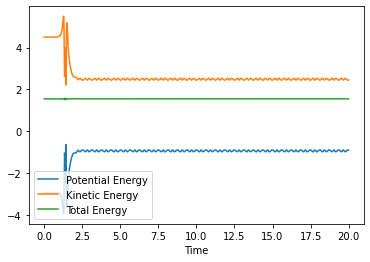

In [33]:
energy = loadtxt(energyfilename)
times = energy[:,0]    # the first column
Epot = energy[:,1]     # the second column
Ekin = energy[:,2]     # the third column
plot (times, Epot, label="Potential Energy")
plot (times, Ekin, label="Kinetic Energy")
plot (times, Epot+Ekin, label="Total Energy")
xlabel("Time")
legend(loc="lower left")
savefig("cluster_fast.png")

In [34]:
cluster_fast = mda.Universe("cluster_fast.xyz")
cluster_fast_view = nv.show_mdanalysis(cluster_fast)
cluster_fast_view

NGLWidget(max_frame=1999)